In [47]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import dask
import dask.dataframe as dd
import graphviz

## Creating the dtype dictionary from Cwm Taf data

In [7]:
df = pd.read_csv('/Volumes/thesis-data/formatted/CT_2013_15.csv', nrows=100000)
dt = df.dtypes.to_dict()

In [8]:
dt['OPCS_13'] = np.dtype('object')
dt['WARD'] = np.dtype('object')
for key, value in dt.items():
    if value == np.dtype('int64'):
        dt[key] = np.dtype('float64')    

## Playing around with plots (just CT data)

In [88]:
ddf = dd.read_csv('/Volumes/thesis-data/cwmtaf.csv', parse_dates=['Bench_Period', 'Period', 'EPISODE_ST', 'EPISODE_END', 'ADMDATE', 'DISCDATE', 'procedure_date_dt'], dtype={'OPCS_11': 'object', 'OPCS_12': 'object', 'ADM_MET': 'object'}, low_memory=False)

In [89]:
ct_data = ddf.compute()

In [ ]:
ct_data.query('SEX == "M"').groupby('Period').LOS.mean().plot(color='royalblue', label='Male')
ct_data.query('SEX == "F"').groupby('Period').LOS.mean().plot(color='indianred', label='Female')
plt.ylabel('Average length of stay [days]')
plt.legend(loc='upper right');

In [ ]:
ct_data[ct_data.south_north == 'South'].groupby('Period').NetCost.mean().plot()
ct_data[ct_data.south_north == 'North'].groupby('Period').NetCost.mean().plot()
;

In [94]:
plt.figure(figsize=(200, 200))
drop_data = ct_data.query('LOS > 14')
sns.boxplot(data=drop_data, x='NetCost', y='HRG_Subchapter', hue='site1');

/Users/henrywilde/anaconda3/envs/hdw-thesis/lib/python3.6/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


## How to concatenate with dask

In [61]:
date_vars = ['Bench_Period', 'Period', 'EPISODE_ST', 'EPISODE_END', 'ADMDATE', 'DISCDATE', 'procedure_date_dt']

In [62]:
cwm1315 = dd.read_csv('/Volumes/thesis-data/formatted/CT_2013_15.csv', parse_dates=date_vars, dtype=dt)
cwm1517 = dd.read_csv('/Volumes/thesis-data/formatted/CT_2015_17.csv', parse_dates=date_vars, dtype=dt)

In [63]:
cwmtaf = dd.concat([cwm1315, cwm1517])
cwmtaf.to_csv('/Volumes/thesis-data/', index=False)

filenames = glob.iglob('/Volumes/thesis-data/*.part')
with open('/Volumes/thesis-data/cwmtaf.csv', 'w') as cwmtaf:
    count = 0
    for filename in filenames:
    # We wish to write the header for the first file, 
    # and skip it on all subsequent .part files.
        if count == 0:
            with open(filename) as f:
                cwmtaf.write(f.read())
            count += 1
        else:
            with open(filename) as f:
                next(f)
                cwmtaf.write(f.read())

KeyboardInterrupt: 

In [64]:
df = dd.read_csv('/Volumes/thesis-data/cwmtaf.csv', parse_dates=date_vars, dtype = {'OPCS_12': 'object'}, low_memory=False)

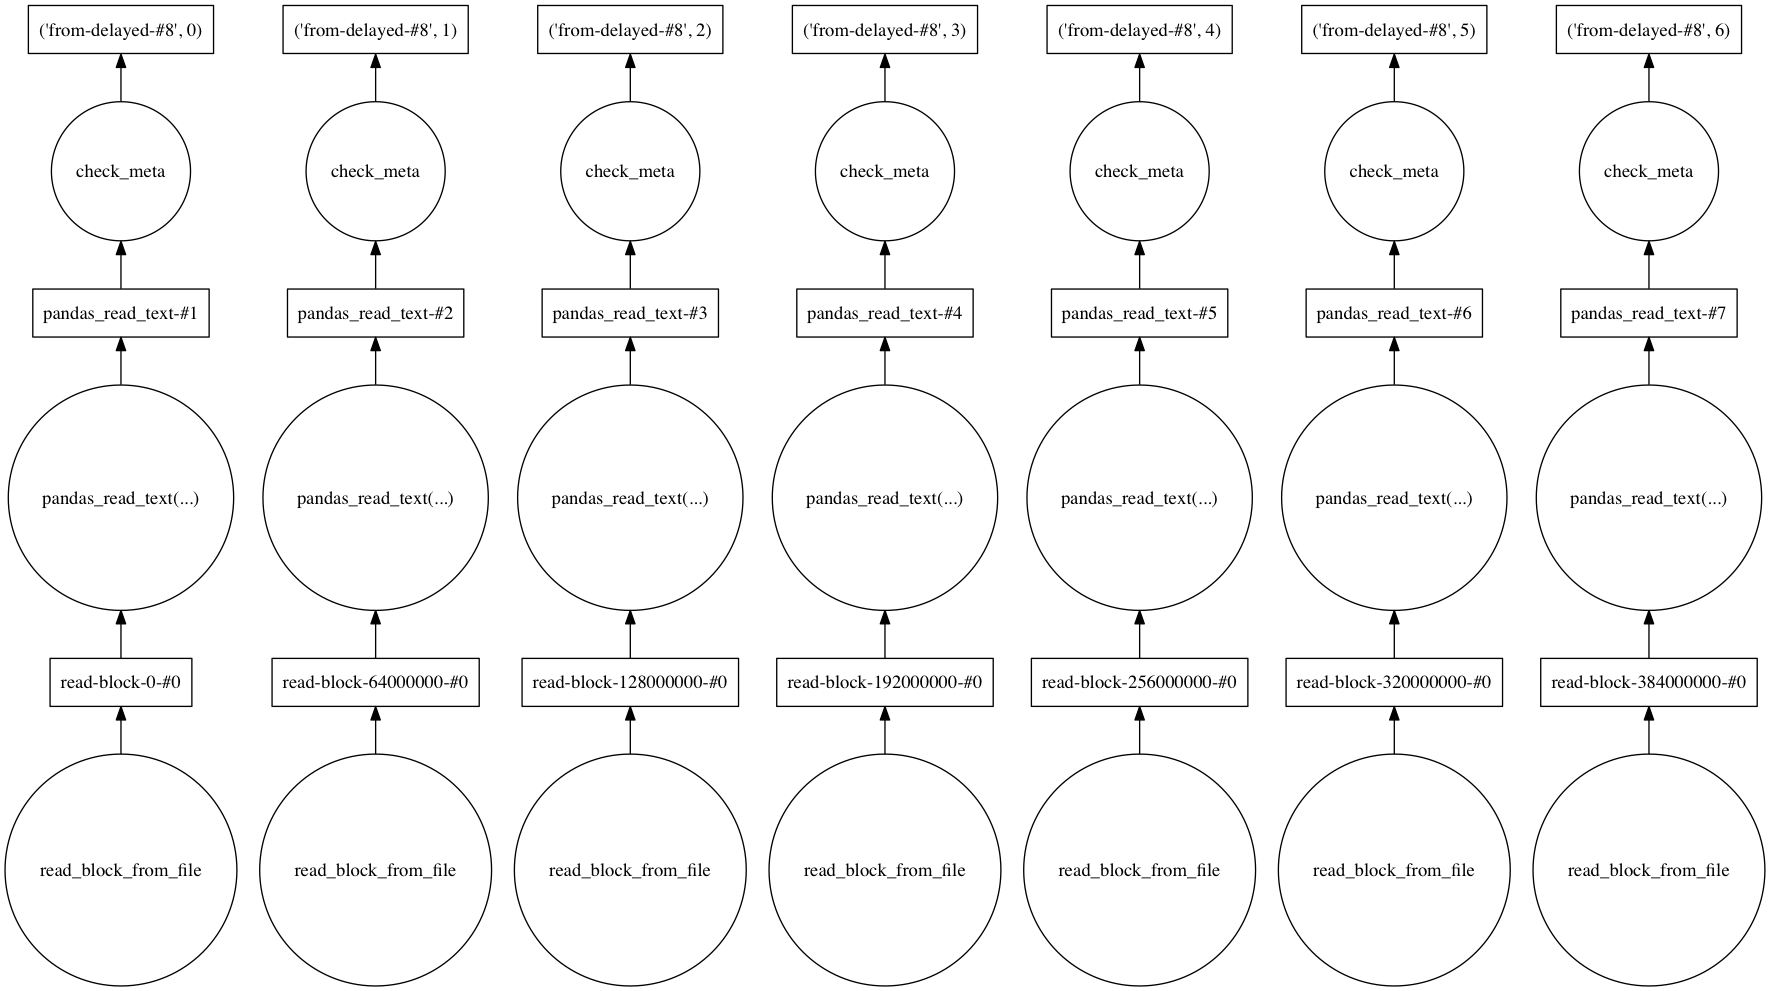

In [65]:
df.visualize()

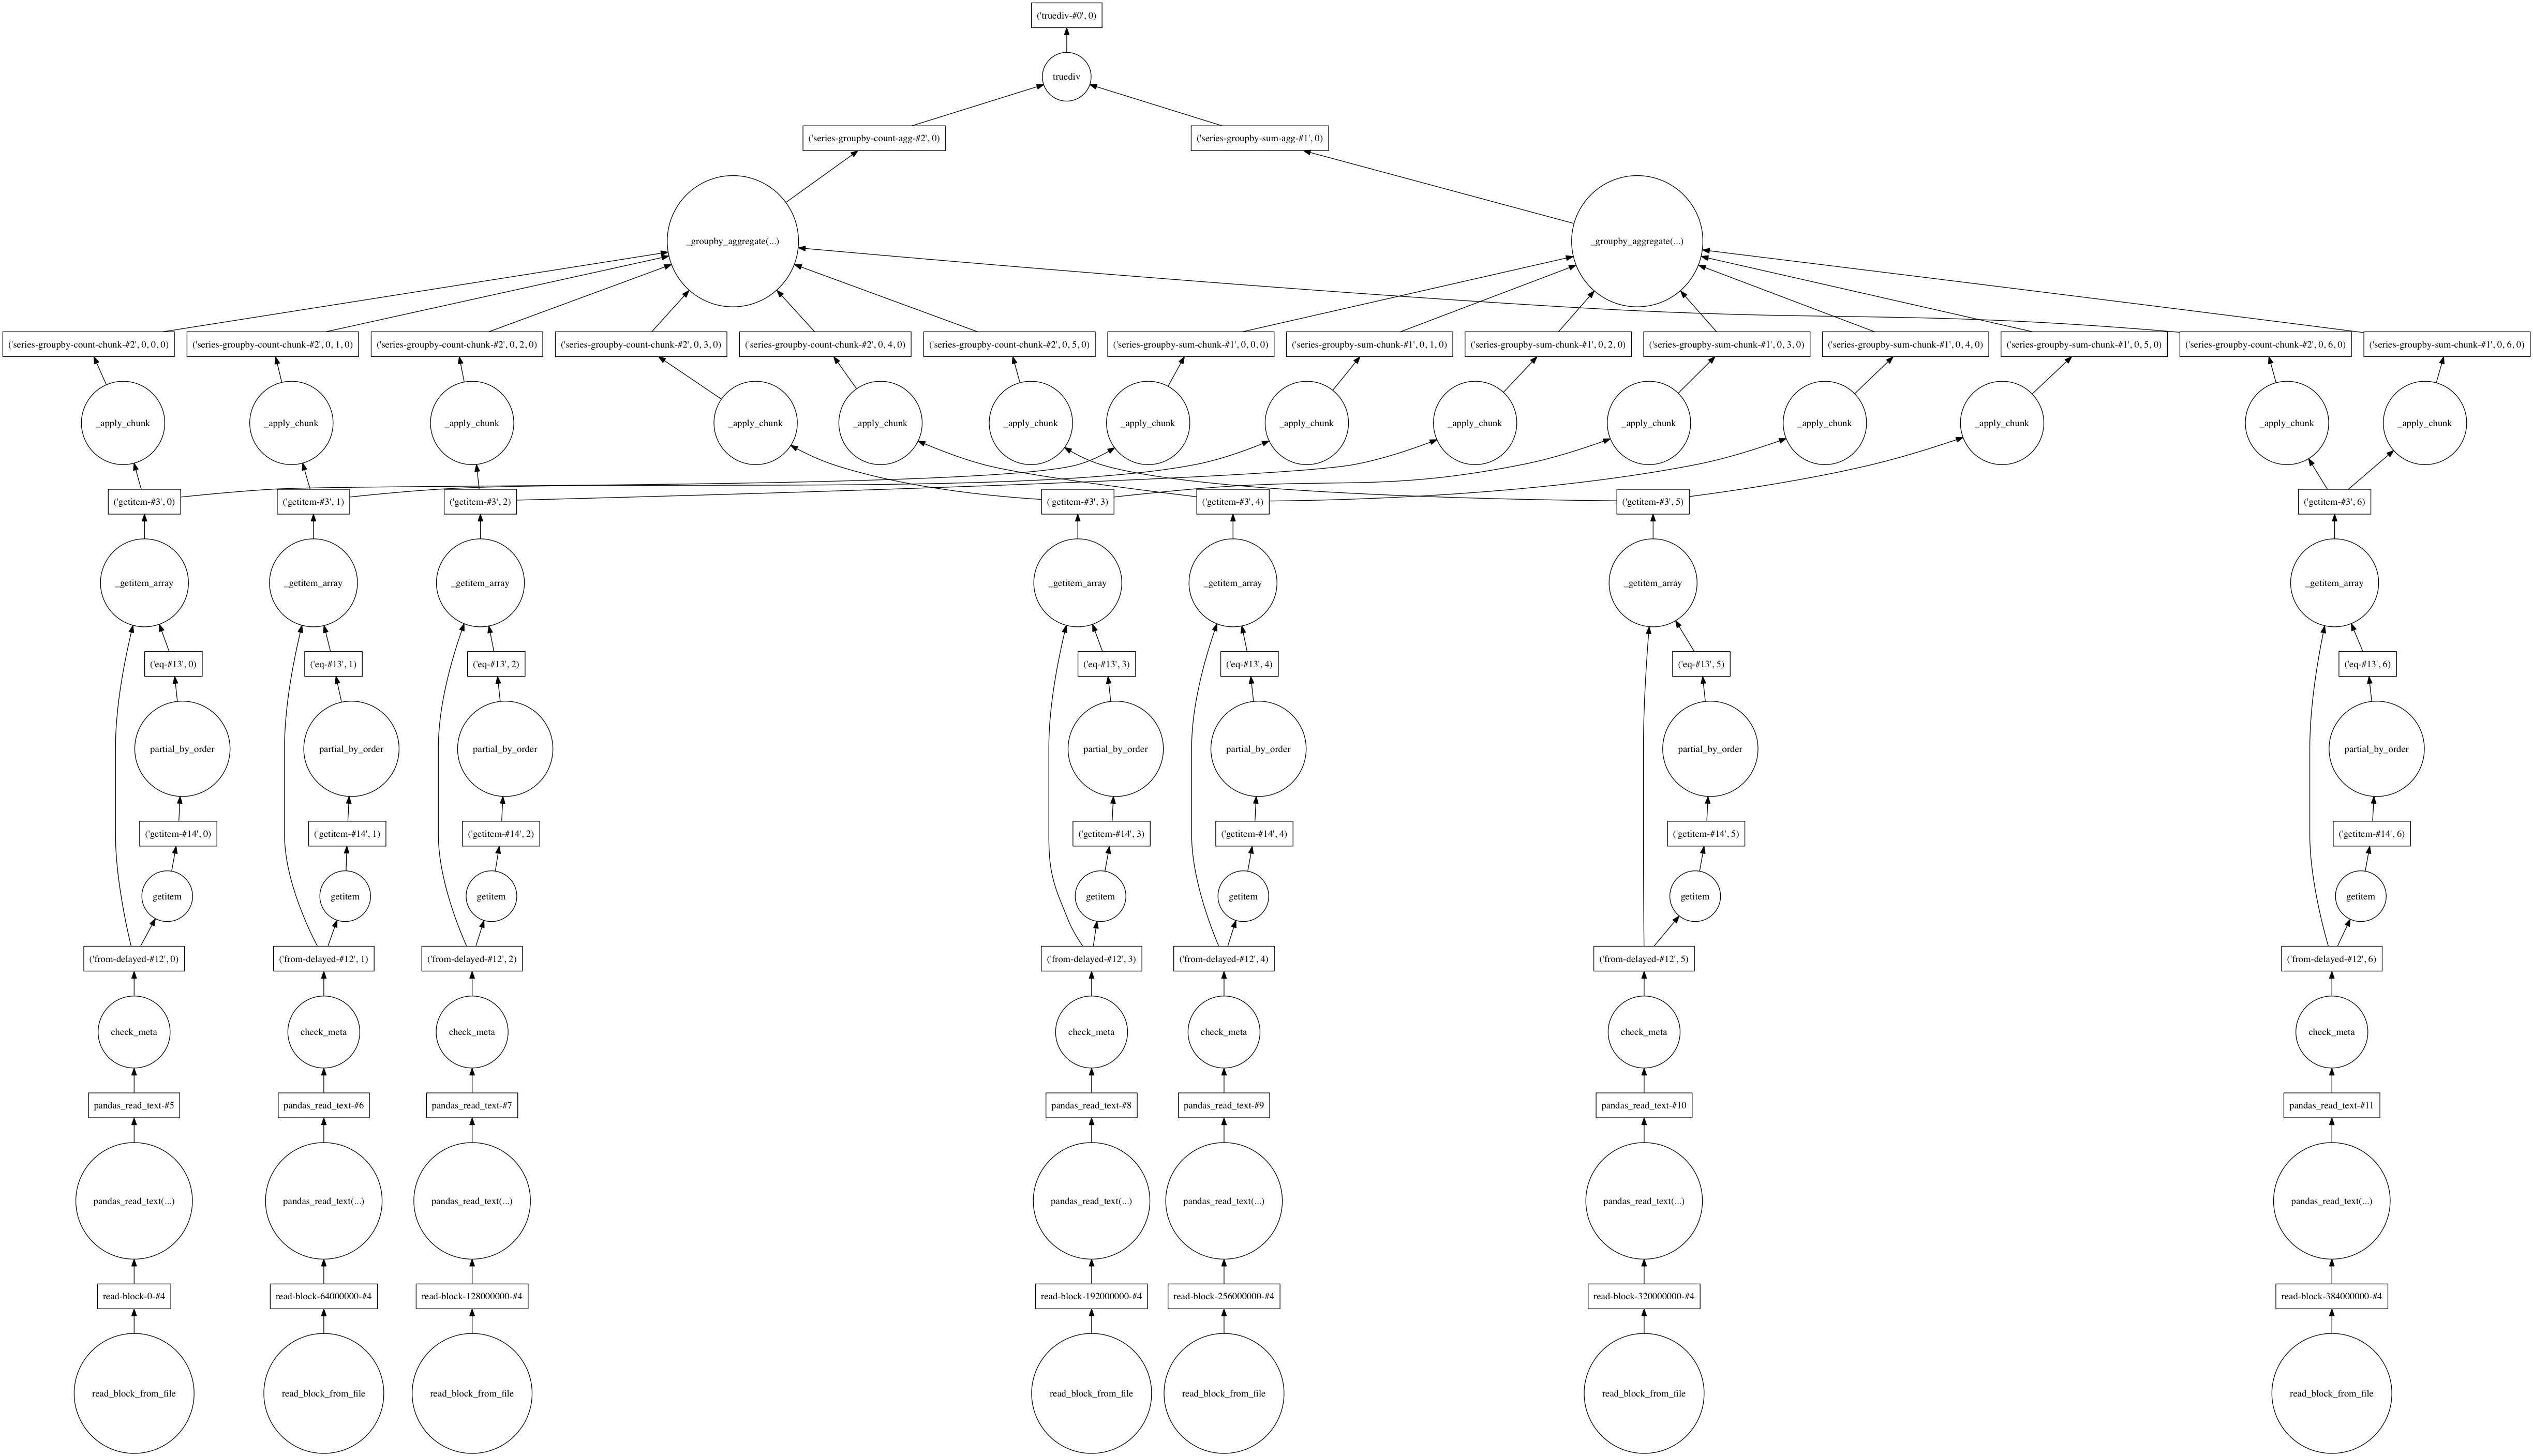

In [66]:
df[df.south_north == 'North'].groupby('Period').LOS.mean().visualize()

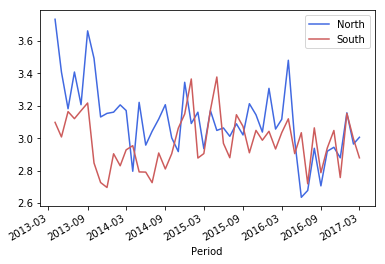

In [67]:
df[df.south_north == 'North'].groupby('Period').LOS.mean().compute().plot(label='North')
df[df.south_north == 'South'].groupby('Period').LOS.mean().compute().plot(label='South')
plt.legend(loc='upper right');

## Working with main.csv

In [73]:
main = dd.read_csv('/Volumes/thesis-data/main.csv', dtype={'OPCS_11': 'object', 'OPCS_12': 'object', 'ADM_MET': 'object'}, parse_dates=date_vars, assume_missing=True, low_memory=False)

CPU times: user 5min 29s, sys: 40.3 s, total: 6min 10s
Wall time: 3min 10s


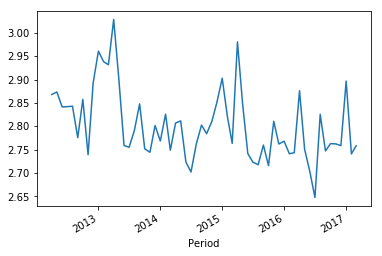

In [75]:
main[main.south_north == 'North'].groupby('Period').LOS.mean().compute().plot(label='North')
main[main.south_north == 'South'].groupby('Period').LOS.mean().compute().plot(label='South')
plt.legend(loc='upper right')

In [111]:
main.groupby('Period').LOS.mean().visualize()

In [126]:
plt.figure(figsize=(200, 200))
drop_data = main.query('LOS > 14').compute()
sns.boxplot(drop_data.LOS, drop_data.HRG_Subchapter, hue=drop_data.site1)
plt.legend(loc='upper left', size=(40, 40));

/Users/henrywilde/anaconda3/envs/hdw-thesis/lib/python3.6/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


TypeError: __init__() got an unexpected keyword argument 'size'

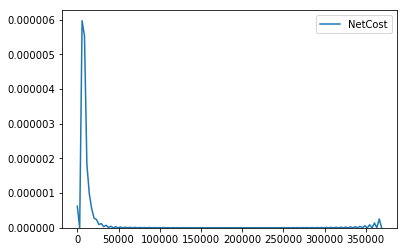

In [125]:
sns.kdeplot(main.NetCost);